# Analysis of YouTube data

We have chosen "3blue1brown" and "Veritasium" channels.
Links: https://www.youtube.com/c/3blue1brown, https://www.youtube.com/c/Veritasium
These two channels have popular science content, especially related to mathematics. The "Veritasium" channel is more viral one and its content is more on the popular science side. Notwithstanding, the "3blue1brown" content is more scietific and reaches more complicated topics.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import re
import nltk
import seaborn as sns
import datetime
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Cleaning and preprocessing data

Reading all previous downloaded and saved data.

In [2]:
with open('ver_vids.txt', 'r') as f:
    videos_ver = f.read()

with open('3blue1brown_vids.txt', 'r') as f:
    videos_bluebrown = f.read()

with open('3blue1brown_vid_stats.txt', 'r') as f:
    stats_bluebrown = f.read()

with open('ver_vid_stats.txt', 'r') as f:
    stats_ver = f.read() 
    
with open('3blue1brown_vid_duration.txt', 'r') as f:
    duration_bluebrown = f.read()

with open('ver_vid_duration.txt', 'r') as f:
    duration_ver = f.read()
    
with open('3blue1brown_vid_comments_df.txt', 'r') as f:
    bluebrown_comments = f.read()

with open('ver_vid_comments_df.txt', 'r') as f:
    ver_comments = f.read()
    
with open('3blue1brown_vid_comments_replies_df.txt', 'r') as f:
    bluebrown_comments_replies = f.read()

with open('ver_vid_comments_replies_df.txt', 'r') as f:
    ver_comments_replies = f.read()
    
    
videos_ver = eval(videos_ver)
videos_bluebrown = eval(videos_bluebrown)
stats_ver = eval(stats_ver)
stats_bluebrown = eval(stats_bluebrown)
bluebrown_comments = eval(bluebrown_comments)
ver_comments = eval(ver_comments)
duration_bluebrown = eval(duration_bluebrown)
duration_ver = eval(duration_ver)
bluebrown_comments_replies = eval(bluebrown_comments_replies)
ver_comments_replies = eval(ver_comments_replies)

Creating all comment dataframes.

In [3]:
bluebrown_comments = pd.DataFrame.from_dict(bluebrown_comments, orient='index', columns=['comment', 'likes', 'date'])
bluebrown_replies = pd.DataFrame.from_dict(bluebrown_comments_replies, orient='index', columns=['comment', 'likes'])
ver_comments = pd.DataFrame.from_dict(ver_comments, orient='index', columns=['comment', 'likes', 'date'])
ver_replies = pd.DataFrame.from_dict(ver_comments_replies, orient='index', columns=['comment', 'likes'])

In [4]:
bluebrown_replies = bluebrown_replies.reset_index()
bluebrown_replies = bluebrown_replies.rename(columns={"index": "date"})
ver_replies = ver_replies.reset_index()
ver_replies = ver_replies.rename(columns={"index": "date"})

All comments together.

In [5]:
bluebrown_all_comments = pd.concat([bluebrown_comments, bluebrown_replies])
bluebrown_all_comments = bluebrown_all_comments.reset_index(drop=True)
ver_all_comments = pd.concat([ver_comments, ver_replies])
ver_all_comments = ver_all_comments.reset_index(drop=True)

Preparing lists of comments to sentiment analysis.

In [6]:
bluebrown_comments_list = list(bluebrown_comments['comment'])
bluebrown_replies_list = list(bluebrown_replies['comment'])
bluebrown_allcomment_list = list(bluebrown_all_comments['comment'])
ver_comments_list = list(ver_comments['comment'])
ver_replies_list = list(ver_replies['comment'])
ver_allcomment_list = list(ver_all_comments['comment'])

Creating channel dataframes.

In [7]:
ver_video_ids = list(map(lambda x:x["snippet"]["resourceId"]["videoId"], videos_ver))
bluebrown_video_ids = list(map(lambda x:x["snippet"]["resourceId"]["videoId"], videos_bluebrown))

In [8]:
def get_vids_data(length, vids, stats, dur):
    title, liked, disliked, views, url, comment, video_id, published_date, video_description, duration = [], [], [], \
                                                                                                         [], [], [], \
                                                                                                         [], [], [], []
    for i in range(length):
        title.append((vids[i])["snippet"]["title"])
        published_date.append((vids[i])["snippet"]["publishedAt"])
        video_description.append((vids[i])["snippet"]["description"])
        liked.append((stats[i])["statistics"]["likeCount"])
        disliked.append((stats[i])["statistics"]["dislikeCount"])
        views.append((stats[i])["statistics"]["viewCount"])
        comment.append((stats[i])["statistics"]["commentCount"])
        video_id.append((vids[i])["snippet"]["resourceId"]["videoId"])
        duration.append((dur[i])["contentDetails"]["duration"])

    return pd.DataFrame({"title": title, "liked": liked, "disliked": disliked, "views": views, "comment": comment,
            "videoid": video_id, "published_date": published_date, "video_description": video_description,
                         "video_duration": duration})

Preparing duration column.

In [9]:
import re
ver_data = get_vids_data(len(ver_video_ids), videos_ver, stats_ver, duration_ver)
bluebrown_data = get_vids_data(len(bluebrown_video_ids), videos_bluebrown, stats_bluebrown, duration_bluebrown)

def change_to_minutes(str_value):
    digit_only = re.findall(r'\d+', str_value)
    if len(digit_only) == 2:
        return int(digit_only[0]) + round(int(digit_only[1])/60, 2)
    else:
        return round(int(digit_only[0]) / 60, 2)

ver_data['video_duration'] = ver_data['video_duration'].apply(change_to_minutes)
bluebrown_data['video_duration'] = bluebrown_data['video_duration'].apply(change_to_minutes)

Setting data types for columns.

In [48]:
ver_data["liked"] = ver_data["liked"].astype("int")
ver_data["disliked"] = ver_data["disliked"].astype("int")
ver_data["comment"] = ver_data["comment"].astype("int")
ver_data["views"] = ver_data["views"].astype("int")
ver_data["published_date"] = ver_data["published_date"].astype('datetime64[ns]')

bluebrown_data["liked"] = bluebrown_data["liked"].astype("int")
bluebrown_data["disliked"] = bluebrown_data["disliked"].astype("int")
bluebrown_data["comment"] = bluebrown_data["comment"].astype("int")
bluebrown_data["views"] = bluebrown_data["views"].astype("int")
bluebrown_data["published_date"] = bluebrown_data["published_date"].astype('datetime64[ns]')

In [178]:
bluebrown_data

,title,liked,disliked,views,comment,videoid,published_date,video_description,video_duration,date_label
0,A few of the best math explainers from this su...,31233,115,552954,795,F3Qixy-r_rQ,2021-10-23 18:11:23,Take a look at the full playlist (really): htt...,12.67,after pandemic start
1,How a Mandelbrot set arises from Newton’s work,27639,158,631456,1255,LqbZpur38nw,2021-10-15 16:41:50,"An intro to holomorphic dynamics, the study of...",27.72,after pandemic start
2,Newton's Fractal (which Newton knew nothing ab...,64261,306,1285143,2868,-RdOwhmqP5s,2021-10-07 02:19:39,Who knew root-finding could be so complicated?...,26.10,after pandemic start
3,The Summer of Math Exposition,29430,218,617254,1725,ojjzXyQCzso,2021-07-16 15:37:16,Announcement for the 2021 Summer of Math Expos...,24.35,after pandemic start
4,A quick trick for computing eigenvalues | Chap...,17295,145,435061,1152,e50Bj7jn9IQ,2021-05-07 19:01:16,How to write the eigenvalues of a 2x2 matrix j...,13.22,after pandemic start
...,...,...,...,...,...,...,...,...,...,...
113,Euler's Formula and Graph Duality,8729,99,386565,322,-9OUyo8NFZg,2015-06-21 05:41:11,"A description of planar graph duality, and how...",7.45,before pandemic
114,Circle Division Solution,14749,99,491276,667,K8P8uFahAgc,2015-05-24 05:05:32,An explanation of a neat circle puzzle involvi...,8.88,before pandemic
115,A Curious Pattern Indeed,9793,191,483797,197,84hEmGHw3J8,2015-04-11 07:17:49,A teaser for some future videos regarding a pa...,1.82,before pandemic
116,Euler's Formula Poem,3925,65,131106,135,zLzLxVeqdQg,2015-03-05 04:14:58,"A poem about why e to the pi i equals -1, base...",1.07,before pandemic


# Analysis of channels' data

Plotting basic stats about channels.

In [191]:
def plot_stats(df):
    fig = plt.figure(figsize=(16, 9))
    fig.subplots_adjust(hspace=0.03, wspace=0.04)
    ylabels = ['comment', 'disliked', 'liked', 'views', 'video_duration']
    n_row = len(ylabels)
    n_col = 1
    for count, ylabel in enumerate(ylabels):
        ax = fig.add_subplot(n_row, n_col, count+1)
        ax.plot(df["published_date"], df[ylabel])
        ax.set_ylabel(ylabel)
    plt.show()

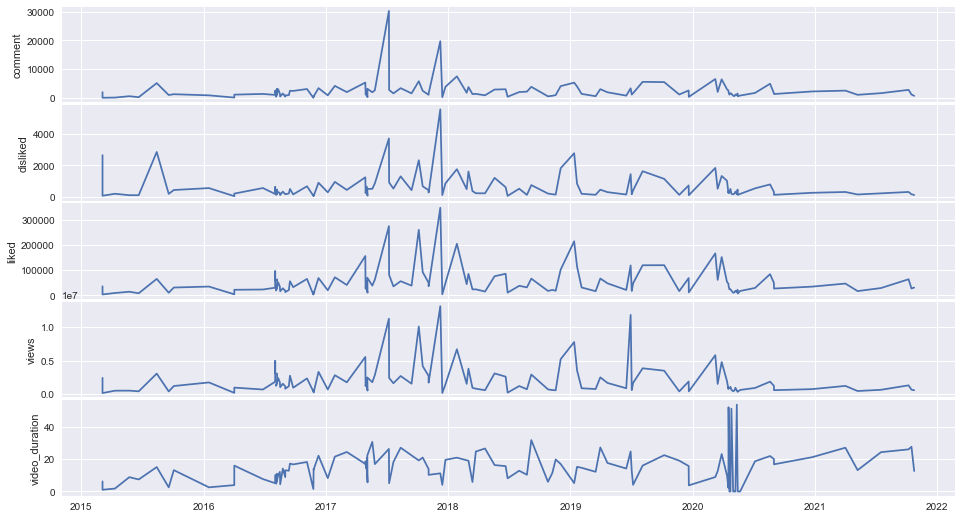

In [192]:
plot_stats(bluebrown_data)

The plot shows number of comments, dislikes, likes, views and video duration for the whole time range when 3blue1brown account was active. We can see that first four chracteristics look very similar in time. On the other hand when we see spikes in video duration, we can observe the drop in views. The outstanding period for video duration is the first months of the pandemic, when the creator started making live tutoring sessions related to easier topics as well.

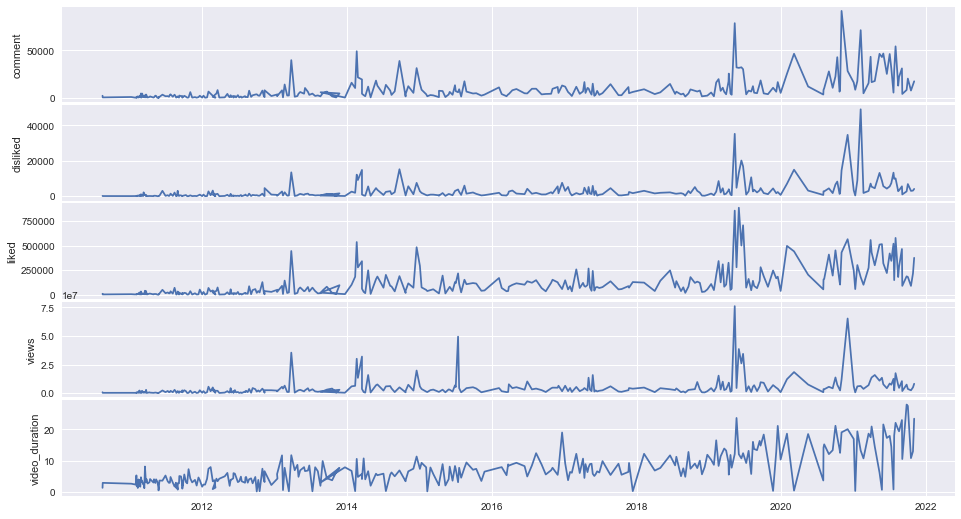

In [193]:
plot_stats(ver_data)

The plot shows number of comments, dislikes, likes, views and video duration for the whole time range when Veritasium account was active. We can see that first four chracteristics look very similar in time. On the other hand when we see spikes in video duration, we can observe the drop in views as before. Since 2019 we can observe more activities in the account.

Below are some basic statistics for all likes and comments.

In [14]:
'mean liked: {}, mean comment count: {}'.format(bluebrown_data['liked'].mean(), bluebrown_data['comment'].mean())

'mean liked: 52142.00847457627, mean comment count: 2484.898305084746'

In [15]:
'mean liked: {}, mean comment count: {}'.format(ver_data['liked'].mean(), ver_data['comment'].mean())

'mean liked: 106359.48456790124, mean comment count: 8096.978395061728'

Below are some basic statistics for 10 most popular videos' likes and comments.

In [16]:
def stats_most_viewed(df):
    data = df.sort_values(by=['views'])[-10:]
    return 'mean liked: {}, mean comment count: {}'.format(data['liked'].mean(), data['comment'].mean())
    
stats_most_viewed(bluebrown_data)

'mean liked: 26626.4, mean comment count: 1462.7'

In [194]:
stats_most_viewed(ver_data)

'mean liked: 554730.7, mean comment count: 34637.4'

For both the Veritasium account scores higher.

In [72]:
bluebrown_data.sort_values(by=['views'])[-5:]

,title,liked,disliked,views,comment,videoid,published_date,video_description,video_duration,date_label
41,The most unexpected answer to a counting puzzle,214826,2775,7782321,5362,HEfHFsfGXjs,2019-01-12 01:15:55,Solution: https://youtu.be/jsYwFizhncE\nEven p...,5.22,before pandemic
64,"But what is a neural network? | Chapter 1, Dee...",260363,2328,10110647,5862,aircAruvnKk,2017-10-04 22:08:13,"What are the neurons, why are there layers, an...",19.22,before pandemic
69,But how does bitcoin actually work?,274991,3716,11283510,30251,bBC-nXj3Ng4,2017-07-07 15:57:15,The math behind cryptocurrencies.\nHelp fund f...,26.35,before pandemic
34,But what is a Fourier series? From heat flow ...,119021,1442,11848664,3415,r6sGWTCMz2k,2019-06-29 18:26:46,"Fourier series, from the heat equation epicycl...",24.78,before pandemic
60,The hardest problem on the hardest test,347985,5575,13162939,19755,OkmNXy7er84,2017-12-08 04:52:24,A difficult Putnam question with an elegant so...,11.25,before pandemic


In [73]:
ver_data.sort_values(by=['views'])[-5:]

,title,liked,disliked,views,comment,videoid,published_date,video_description,video_duration,date_label
198,World's Roundest Object!,445722,13478,35423938,39767,ZMByI4s-D-Y,2013-03-25 02:28:38,The world's roundest object helps solve the lo...,11.73,before pandemic
57,World's Lightest Solid!,887583,13207,38585919,31567,AeJ9q45PfD0,2019-05-31 10:43:43,Aerogels are the world's lightest (least dense...,12.03,before pandemic
140,Backspin Basketball Flies Off Dam,216866,3799,49408177,5845,2OSrvzNW9FE,2015-07-14 16:33:49,How far would a basketball with backspin go?\n...,3.02,before pandemic
27,These are the asteroids to worry about,566171,34660,65301213,28282,4Wrc4fHSCpw,2020-11-30 10:13:29,Stephen Hawking thought an asteroid impact pos...,20.10,after pandemic start
59,"Why Are 96,000,000 Black Balls on This Reservoir?",858092,35222,76098949,78760,uxPdPpi5W4o,2019-05-10 17:51:08,I took a boat through 96 million black plastic...,12.12,before pandemic


Now we would like to analyse the relation between number of views and likes.

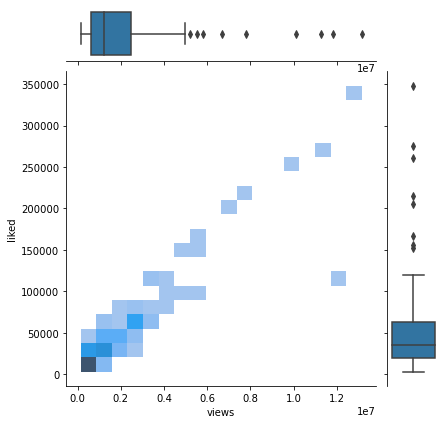

In [74]:
g = sns.JointGrid(data=bluebrown_data, x="views", y="liked")
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

We can see that the relation is linear and directly proportional. We observe the highest density for the lower values in both. The most popular videos are the outliers. 

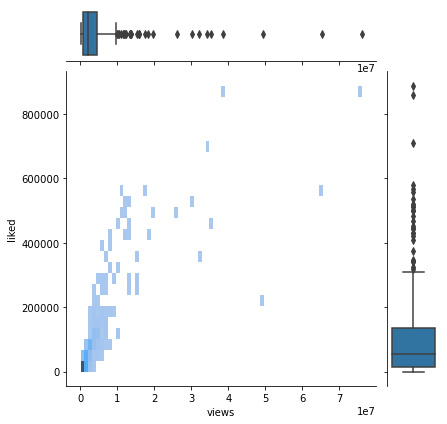

In [75]:
g = sns.JointGrid(data=ver_data, x="views", y="liked")
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

It is similar case as for 3blue1brown channel, but there are more outliers.

We have noticed changes in 3blue1brown activity associated with the pandemic. Because of that we created the additional column with 'before pandemic' and 'after pandemic start' labels.

In [53]:
def get_labels_date(df):
    return ['before pandemic' if date < datetime.datetime.strptime("2020-03-01", "%Y-%m-%d") else 'after pandemic start' for date in df['published_date']]

bluebrown_labels_date = get_labels_date(bluebrown_data)
ver_labels_date = get_labels_date(ver_data)
bluebrown_data['date_label'] = bluebrown_labels_date
ver_data['date_label'] = ver_labels_date

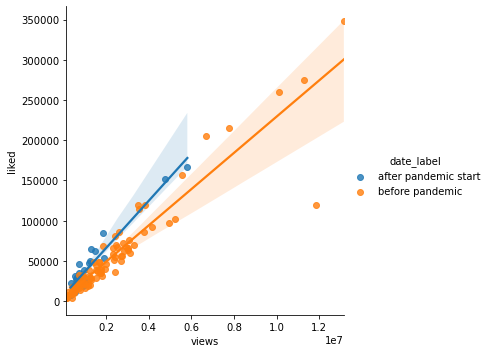

In [54]:
sns.lmplot(x="views", y="liked", hue='date_label', data=bluebrown_data)

We can see that for both time periods there is linear connection between data. However, the 'after pandemic start' regression line scores more likes for the same amount of views. It might be caused by new viewers inflow associated with new tutoring content and online classes.

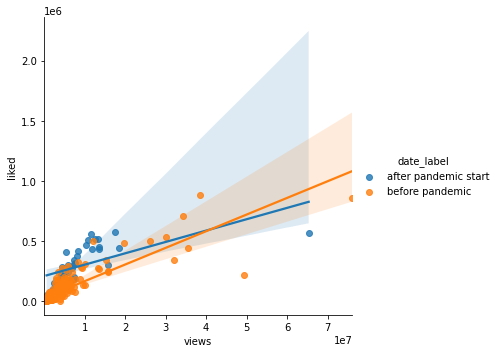

In [55]:
sns.lmplot(x="views", y="liked", hue='date_label', data=ver_data)

For the Veritasium channel we don't see such relation. The pandemic did not affect his channels' content.

We wanted to check relation for frequency of uploads with views and likes. For this purpose, we split activity time range for quarters.

In [56]:
dates_bluebrown = pd.date_range(start="2015-01-01",end="2021-09-01", periods=28)
dates_ver = pd.date_range(start="2010-01-01",end="2021-09-01", periods=48)

In [57]:
def get_num_of_vids_in_timeperiod(df, start_date, stop_date):
    mask = (df['published_date'] > start_date) & (df['published_date'] <= stop_date)
    return len(df.loc[mask])

In [58]:
def get_all_num_of_vids(df, dates):
    start, num_of_vids = 0, []
    for i in range(len(dates)-1):
        num = get_num_of_vids_in_timeperiod(df, dates[start], dates[start+1])
        num_of_vids.append([num, dates[start], dates[start+1]])
        start +=1
    return num_of_vids

In [59]:
all_vids_bluebrown = get_all_num_of_vids(bluebrown_data, dates_bluebrown)
all_vids_ver = get_all_num_of_vids(ver_data, dates_ver)

In [76]:
all_vids_bluebrown

[[2, Timestamp('2015-01-01 00:00:00'), Timestamp('2015-04-01 04:26:40')],
 [3, Timestamp('2015-04-01 04:26:40'), Timestamp('2015-06-30 08:53:20')],
 [2, Timestamp('2015-06-30 08:53:20'), Timestamp('2015-09-28 13:20:00')],
 [1, Timestamp('2015-09-28 13:20:00'), Timestamp('2015-12-27 17:46:40')],
 [1, Timestamp('2015-12-27 17:46:40'), Timestamp('2016-03-26 22:13:20')],
 [2, Timestamp('2016-03-26 22:13:20'), Timestamp('2016-06-25 02:40:00')],
 [15, Timestamp('2016-06-25 02:40:00'), Timestamp('2016-09-23 07:06:40')],
 [6, Timestamp('2016-09-23 07:06:40'), Timestamp('2016-12-22 11:33:20')],
 [3, Timestamp('2016-12-22 11:33:20'), Timestamp('2017-03-22 16:00:00')],
 [13, Timestamp('2017-03-22 16:00:00'), Timestamp('2017-06-20 20:26:40')],
 [5, Timestamp('2017-06-20 20:26:40'), Timestamp('2017-09-19 00:53:20')],
 [6, Timestamp('2017-09-19 00:53:20'), Timestamp('2017-12-18 05:20:00')],
 [5, Timestamp('2017-12-18 05:20:00'), Timestamp('2018-03-18 09:46:40')],
 [3, Timestamp('2018-03-18 09:46:40'

The most frequent time periods are (2016-06, 2016-09), (2017-03, 2017-06-20) and (2020-03-08, 2020-06-07). The last one is connected with the pandemic maths tutorials. The first two don't generate spikes in views and likes data.

In [62]:
all_vids_ver

[[0,
  Timestamp('2010-01-01 00:00:00'),
  Timestamp('2010-04-01 15:49:47.234042553')],
 [0,
  Timestamp('2010-04-01 15:49:47.234042553'),
  Timestamp('2010-07-01 07:39:34.468085106')],
 [2,
  Timestamp('2010-07-01 07:39:34.468085106'),
  Timestamp('2010-09-29 23:29:21.702127660')],
 [0,
  Timestamp('2010-09-29 23:29:21.702127660'),
  Timestamp('2010-12-29 15:19:08.936170212')],
 [26,
  Timestamp('2010-12-29 15:19:08.936170212'),
  Timestamp('2011-03-30 07:08:56.170212768')],
 [16,
  Timestamp('2011-03-30 07:08:56.170212768'),
  Timestamp('2011-06-28 22:58:43.404255320')],
 [20,
  Timestamp('2011-06-28 22:58:43.404255320'),
  Timestamp('2011-09-27 14:48:30.638297872')],
 [10,
  Timestamp('2011-09-27 14:48:30.638297872'),
  Timestamp('2011-12-27 06:38:17.872340424')],
 [13,
  Timestamp('2011-12-27 06:38:17.872340424'),
  Timestamp('2012-03-26 22:28:05.106382976')],
 [10,
  Timestamp('2012-03-26 22:28:05.106382976'),
  Timestamp('2012-06-25 14:17:52.340425536')],
 [11,
  Timestamp('2012-

The most frequent time period is (2010-01, 2011-09). This is the very beginning of Veritasium channel. As before, this time does not generate spikes in views and likes data. Overall, he uploads a constant number of videos.

We wanted to check the relation between views and video duration.

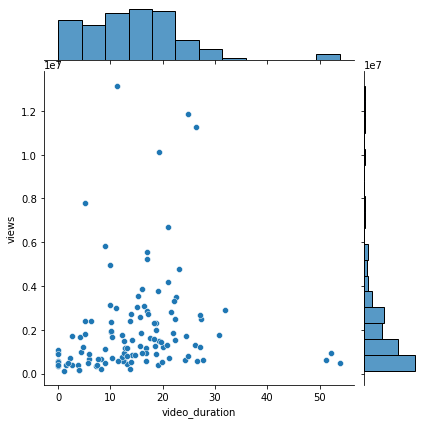

In [85]:
sns.jointplot(data=bluebrown_data, x="video_duration", y="views")

We can see that the most views have videos that last between 5 and 20 minutes. The data with duration higher than 50 minutes are the mentioned before pandemic tutorials.

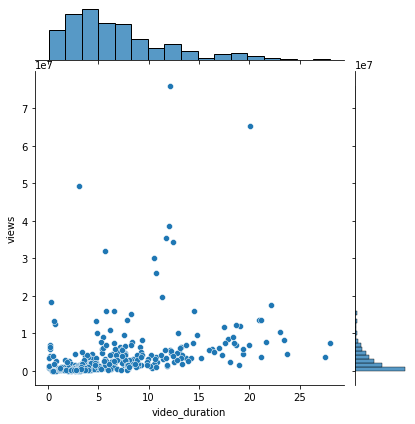

In [84]:
sns.jointplot(data=ver_data, x="video_duration", y="views")

The Veritasium channel has smaller gap between the shortes and the longest video. 

# Comments analysis

We wanted to analyse sentiment of comments' data. We used Natural Language Processing packages. First we remove special characters and numbers from the comments. To do so we use regex. 
We will perform analysis on three comments' datasets: all comments, only top thread comments and only replies.

In [20]:
def clean_text(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

In [145]:
bluebrown_cleaned_comments_all = [clean_text(i) for i in bluebrown_allcomment_list]
ver_cleaned_comments_all = [clean_text(i) for i in ver_allcomment_list]

In [146]:
bluebrown_cleaned_comments = [clean_text(i) for i in bluebrown_comments_list]
ver_cleaned_comments = [clean_text(i) for i in ver_comments_list]

In [147]:
bluebrown_cleaned_comments_rep = [clean_text(i) for i in bluebrown_replies_list]
ver_cleaned_comments_rep = [clean_text(i) for i in ver_replies_list]

To perform tokenization (braking text into smaller piecies on word level) we use word_tokenize build in function.

In [148]:
bluebrown_tokenized_comments_all = [word_tokenize(i) for i in bluebrown_cleaned_comments_all]
ver_tokenized_comments_all = [word_tokenize(i) for i in ver_cleaned_comments_all]
bluebrown_tokenized_comments = [word_tokenize(i) for i in bluebrown_cleaned_comments]
ver_tokenized_comments = [word_tokenize(i) for i in ver_cleaned_comments]
bluebrown_tokenized_comments_rep = [word_tokenize(i) for i in bluebrown_cleaned_comments_rep]
ver_tokenized_comments_rep = [word_tokenize(i) for i in ver_cleaned_comments_rep]

Next, we remove stop words and use 'stopwords.words('english')' database.

In [149]:
def remove_stopwords(words):
    return [i for i in words if i.lower() not in stopwords.words('english')]

In [150]:
bluebrown_tokenized_comments_all = [remove_stopwords(i) for i in bluebrown_tokenized_comments_all]
ver_tokenized_comments_all = [remove_stopwords(i) for i in ver_tokenized_comments_all]
bluebrown_tokenized_comments = [remove_stopwords(i) for i in bluebrown_tokenized_comments]
ver_tokenized_comments = [remove_stopwords(i) for i in ver_tokenized_comments]
bluebrown_tokenized_comments_rep = [remove_stopwords(i) for i in bluebrown_tokenized_comments_rep]
ver_tokenized_comments_rep = [remove_stopwords(i) for i in ver_tokenized_comments_rep]

To add Parts of Speech tags we use nltks' pos_tag function.

In [151]:
bluebrown_tag_comments_all = [pos_tag(i) for i in bluebrown_tokenized_comments_all]
ver_tag_comments_all = [pos_tag(i) for i in ver_tokenized_comments_all]
bluebrown_tag_comments = [pos_tag(i) for i in bluebrown_tokenized_comments]
ver_tag_comments = [pos_tag(i) for i in ver_tokenized_comments]
bluebrown_tag_comments_rep = [pos_tag(i) for i in bluebrown_tokenized_comments_rep]
ver_tag_comments_rep = [pos_tag(i) for i in ver_tokenized_comments_rep]

We change tags' form to perform Lemmatization.

In [152]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

In [153]:
def change_tags(comments_list):
    new_comments = []
    for comment in comments_list:
        new = []
        for word, tag in comment:
            new.append(tuple([word, pos_dict.get(tag[0])]))
        new_comments.append(new)
    return new_comments

In [154]:
bluebrown_tag_comments_all = change_tags(bluebrown_tag_comments_all)
ver_tag_comments_all = change_tags(ver_tag_comments_all)
bluebrown_tag_comments = change_tags(bluebrown_tag_comments)
ver_tag_comments = change_tags(ver_tag_comments)
bluebrown_tag_comments_rep = change_tags(bluebrown_tag_comments_rep)
ver_tag_comments_rep = change_tags(ver_tag_comments_rep)

To perform lemmanization we use WordNetLemmatizer().

In [155]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(comments_list):
    lemma_rew_list = []
    for comment in comments_list:
        lemma_rew = " "
        for word, pos in comment:
            if not pos:
                lemma_rew = lemma_rew + " " + word
            else:
                lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
                lemma_rew = lemma_rew + " " + lemma
        lemma_rew_list.append(lemma_rew)
    return lemma_rew_list

In [156]:
bluebrown_lem_comments_all = lemmatize(bluebrown_tag_comments_all)
ver_lem_comments_all = lemmatize(ver_tag_comments_all)
bluebrown_lem_comments = lemmatize(bluebrown_tag_comments)
ver_lem_comments = lemmatize(ver_tag_comments)
bluebrown_lem_comments_rep = lemmatize(bluebrown_tag_comments_rep)
ver_lem_comments_rep = lemmatize(ver_tag_comments_rep)

To get the subjectivity and polarity we use TextBlob library.

In [157]:
def subjectivity(comment):
    return TextBlob(comment).sentiment.subjectivity

def polarity(comment):
    return TextBlob(comment).sentiment.polarity

We create dataframes with all indicators.

In [158]:
bluebrown_comments_df_all = pd.DataFrame()
ver_comments_df_all = pd.DataFrame()
bluebrown_comments_df_all['bluebrown_lem_comments'] = bluebrown_lem_comments_all
ver_comments_df_all['ver_lem_comments'] = ver_lem_comments_all
bluebrown_comments_df_all['bluebrown_polarity'] = bluebrown_comments_df_all['bluebrown_lem_comments'].apply(polarity)
bluebrown_comments_df_all['bluebrown_subj'] = bluebrown_comments_df_all['bluebrown_lem_comments'].apply(subjectivity)
ver_comments_df_all['ver_polarity'] = ver_comments_df_all['ver_lem_comments'].apply(polarity)
ver_comments_df_all['ver_subj'] = ver_comments_df_all['ver_lem_comments'].apply(subjectivity)

bluebrown_comments_df = pd.DataFrame()
ver_comments_df = pd.DataFrame()
bluebrown_comments_df['bluebrown_lem_comments'] = bluebrown_lem_comments
ver_comments_df['ver_lem_comments'] = ver_lem_comments
bluebrown_comments_df['bluebrown_polarity'] = bluebrown_comments_df['bluebrown_lem_comments'].apply(polarity)
bluebrown_comments_df['bluebrown_subj'] = bluebrown_comments_df['bluebrown_lem_comments'].apply(subjectivity)
ver_comments_df['ver_polarity'] = ver_comments_df['ver_lem_comments'].apply(polarity)
ver_comments_df['ver_subj'] = ver_comments_df['ver_lem_comments'].apply(subjectivity)

bluebrown_comments_df_rep = pd.DataFrame()
ver_comments_df_rep = pd.DataFrame()
bluebrown_comments_df_rep['bluebrown_lem_comments'] = bluebrown_lem_comments_rep
ver_comments_df_rep['ver_lem_comments'] = ver_lem_comments_rep
bluebrown_comments_df_rep['bluebrown_polarity'] = bluebrown_comments_df_rep['bluebrown_lem_comments'].apply(polarity)
bluebrown_comments_df_rep['bluebrown_subj'] = bluebrown_comments_df_rep['bluebrown_lem_comments'].apply(subjectivity)
ver_comments_df_rep['ver_polarity'] = ver_comments_df_rep['ver_lem_comments'].apply(polarity)
ver_comments_df_rep['ver_subj'] = ver_comments_df_rep['ver_lem_comments'].apply(subjectivity)

In [159]:
bluebrown_comments_df_all.head()

,bluebrown_lem_comments,bluebrown_polarity,bluebrown_subj
0,Wait minute think librarian need,0.000000,0.000000
1,go hold forth rationality use term mantra co...,-0.140625,0.278125
2,Love video Note P H E P E P H E P E H P E H ...,0.126667,0.631667
3,Loved video finally drive logic Bayes theore...,0.350000,0.900000
4,think event H hypothesis E evidence instead ...,0.083333,0.400000


For comparision we use also a second sentiment analysis library.

In [160]:
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(comment):
    return analyzer.polarity_scores(comment)['compound']

bluebrown_comments_df_all['bluebrown_vader'] = bluebrown_comments_df_all['bluebrown_lem_comments'].apply(vader_sentiment)
ver_comments_df_all['ver_vader'] = ver_comments_df_all['ver_lem_comments'].apply(vader_sentiment)
bluebrown_comments_df['bluebrown_vader'] = bluebrown_comments_df['bluebrown_lem_comments'].apply(vader_sentiment)
ver_comments_df['ver_vader'] = ver_comments_df['ver_lem_comments'].apply(vader_sentiment)
bluebrown_comments_df_rep['bluebrown_vader'] = bluebrown_comments_df_rep['bluebrown_lem_comments'].apply(vader_sentiment)
ver_comments_df_rep['ver_vader'] = ver_comments_df_rep['ver_lem_comments'].apply(vader_sentiment)

In [161]:
bluebrown_comments_df_all

,bluebrown_lem_comments,bluebrown_polarity,bluebrown_subj,bluebrown_vader
0,Wait minute think librarian need,0.000000,0.000000,0.0000
1,go hold forth rationality use term mantra co...,-0.140625,0.278125,-0.4404
2,Love video Note P H E P E P H E P E H P E H ...,0.126667,0.631667,-0.1027
3,Loved video finally drive logic Bayes theore...,0.350000,0.900000,0.5994
4,think event H hypothesis E evidence instead ...,0.083333,0.400000,0.8689
...,...,...,...,...
2664,Dharmin Shah good one,0.700000,0.600000,0.4404
2665,chance right,0.285714,0.535714,0.2500
2666,bound happen,0.000000,0.000000,0.0000
2667,th,0.000000,0.000000,0.0000


To label subjectivity and polarity data we use functions defined below.

In [162]:
def get_subj_interpretation(subj):
    return 'subjective' if subj>=0.5 else 'objective' 

In [163]:
def get_pol_interpretation(num):
    return 'positive' if num>=0.5 else 'negative' if num<=-0.5 else 'neutral'

In [164]:
ver_comments_df_all['polarity_interpretation'] = ver_comments_df_all['ver_polarity'].apply(get_pol_interpretation)
ver_comments_df_all['subj_interpretation'] = ver_comments_df_all['ver_subj'].apply(get_subj_interpretation)
ver_comments_df_all['vader_interpretation'] = ver_comments_df_all['ver_vader'].apply(get_pol_interpretation)
bluebrown_comments_df_all['polarity_interpretation'] = bluebrown_comments_df_all['bluebrown_polarity'].apply(get_pol_interpretation)
bluebrown_comments_df_all['subj_interpretation'] = bluebrown_comments_df_all['bluebrown_subj'].apply(get_subj_interpretation)
bluebrown_comments_df_all['vader_interpretation'] = bluebrown_comments_df_all['bluebrown_vader'].apply(get_pol_interpretation)

ver_comments_df['polarity_interpretation'] = ver_comments_df['ver_polarity'].apply(get_pol_interpretation)
ver_comments_df['subj_interpretation'] = ver_comments_df['ver_subj'].apply(get_subj_interpretation)
ver_comments_df['vader_interpretation'] = ver_comments_df['ver_vader'].apply(get_pol_interpretation)
bluebrown_comments_df['polarity_interpretation'] = bluebrown_comments_df['bluebrown_polarity'].apply(get_pol_interpretation)
bluebrown_comments_df['subj_interpretation'] = bluebrown_comments_df['bluebrown_subj'].apply(get_subj_interpretation)
bluebrown_comments_df['vader_interpretation'] = bluebrown_comments_df['bluebrown_vader'].apply(get_pol_interpretation)

ver_comments_df_rep['polarity_interpretation'] = ver_comments_df_rep['ver_polarity'].apply(get_pol_interpretation)
ver_comments_df_rep['subj_interpretation'] = ver_comments_df_rep['ver_subj'].apply(get_subj_interpretation)
ver_comments_df_rep['vader_interpretation'] = ver_comments_df_rep['ver_vader'].apply(get_pol_interpretation)
bluebrown_comments_df_rep['polarity_interpretation'] = bluebrown_comments_df_rep['bluebrown_polarity'].apply(get_pol_interpretation)
bluebrown_comments_df_rep['subj_interpretation'] = bluebrown_comments_df_rep['bluebrown_subj'].apply(get_subj_interpretation)
bluebrown_comments_df_rep['vader_interpretation'] = bluebrown_comments_df_rep['bluebrown_vader'].apply(get_pol_interpretation)

In [165]:
bluebrown_comments_df

,bluebrown_lem_comments,bluebrown_polarity,bluebrown_subj,bluebrown_vader,polarity_interpretation,subj_interpretation,vader_interpretation
0,Wait minute think librarian need,0.000000,0.000000,0.0000,neutral,objective,neutral
1,go hold forth rationality use term mantra co...,-0.140625,0.278125,-0.4404,neutral,objective,neutral
2,Love video Note P H E P E P H E P E H P E H ...,0.126667,0.631667,-0.1027,neutral,subjective,neutral
3,Loved video finally drive logic Bayes theore...,0.350000,0.900000,0.5994,neutral,subjective,positive
4,think event H hypothesis E evidence instead ...,0.083333,0.400000,0.8689,neutral,objective,positive
...,...,...,...,...,...,...,...
1933,First wow,0.175000,0.666667,0.5859,neutral,subjective,positive
1934,th,0.000000,0.000000,0.0000,neutral,objective,neutral
1935,Yay,0.000000,0.000000,0.5267,neutral,objective,positive
1936,Hi,0.000000,0.000000,0.0000,neutral,objective,neutral


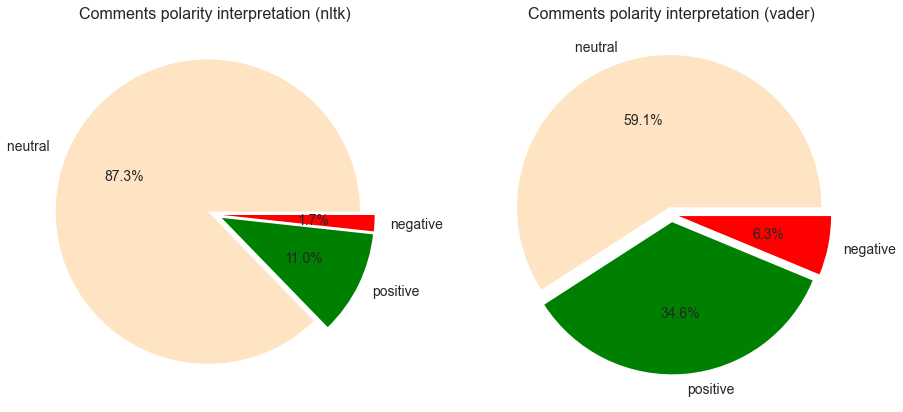

In [166]:
def pie_plots(df, x='polarity_interpretation', y='', 
                labels=['neutral ', 'positive', 'negative'], colors=('bisque', 'green', 'red'), 
                titles = ["Comments polarity interpretation (nltk)", "Comments polarity interpretation (vader)"], 
              explode = (0.05, 0.05, 0.05)):
    type_series = df[x].value_counts()
    type_series_p = round((type_series / sum(type_series)) * 100, 2)
    plt.figure(figsize=(15,15))
    plt.style.use('seaborn')
    plt.subplot(1,2,1)
    plt.pie(type_series_p, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors, 
            textprops={'fontsize': 14})
    plt.title(titles[0], fontsize=16)
    if y:
        type_series2 = df[y].value_counts()
        type_series_p2 = round((type_series2 / sum(type_series2)) * 100, 2)
        plt.subplot(1,2,2)
        plt.pie(type_series_p2, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors, 
                textprops={'fontsize': 14})
        plt.title(titles[1], fontsize=16)
pie_plots(bluebrown_comments_df_all, y='vader_interpretation')

We can see that for the second way of counting polarity there are more positive and negative comments and less neutral comments.

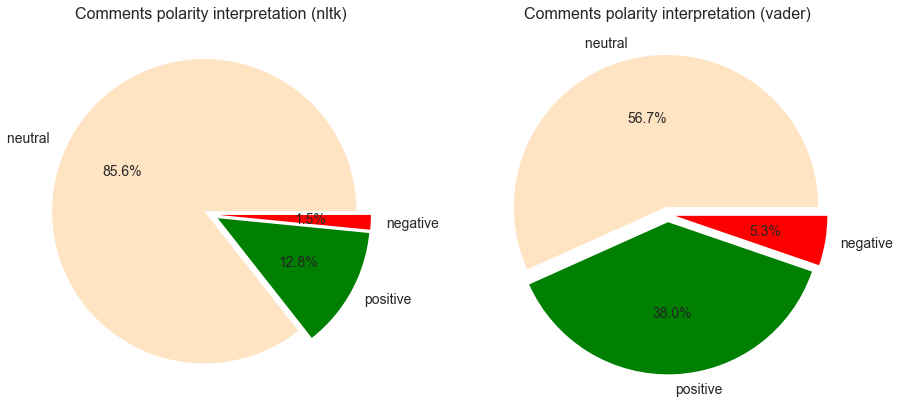

In [167]:
pie_plots(bluebrown_comments_df, y='vader_interpretation')

For the comments data withour replies the propotions look similar.

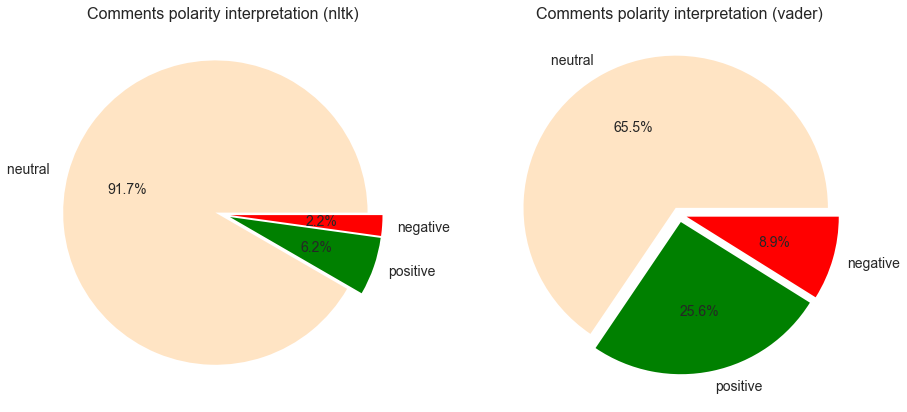

In [168]:
pie_plots(bluebrown_comments_df_rep, y='vader_interpretation')

For replies data the vast majority are neutral for the nltk package. But the difference between two ways of counting the polarity remains.

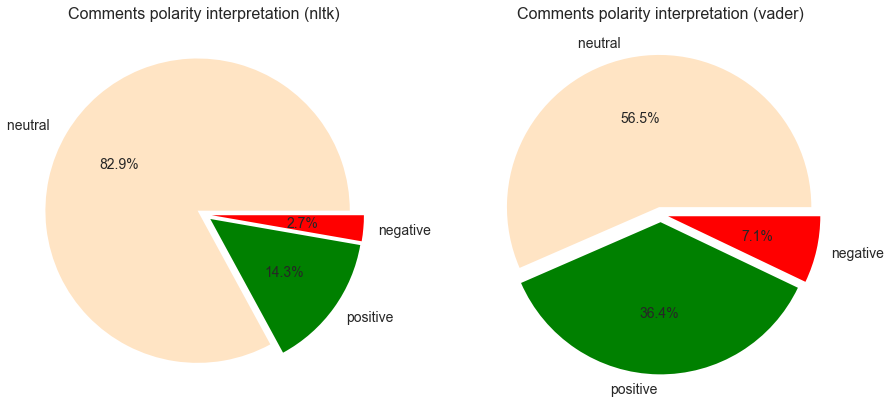

In [142]:
pie_plots(ver_comments_df, y='vader_interpretation')

For the second account (Veritasium) we observe the similar relations for all three datasets.

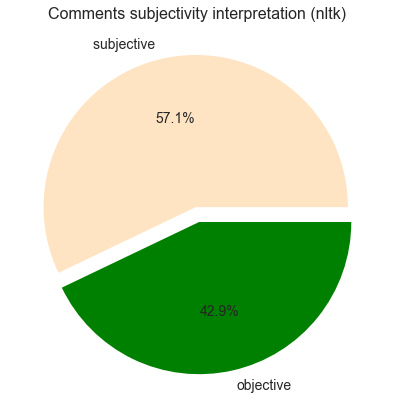

In [195]:
pie_plots(df=bluebrown_comments_df_all, x='subj_interpretation',
                labels=['subjective ', 'objective'], colors=('bisque', 'green'), 
                titles = ["Comments subjectivity interpretation (nltk)"], explode = (0.05, 0.05))

We don't see a big difference between subjective and objective number of comments.

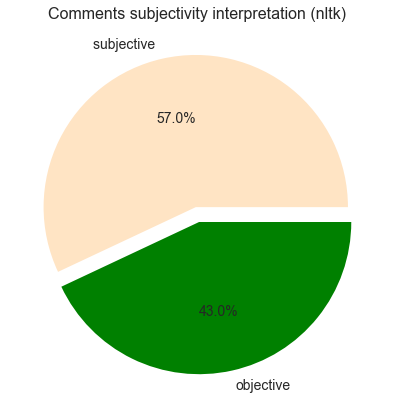

In [196]:
pie_plots(df=ver_comments_df_all, x='subj_interpretation',
                labels=['subjective ', 'objective'], colors=('bisque', 'green'), 
                titles = ["Comments subjectivity interpretation (nltk)"], explode = (0.05, 0.05))

As before, we don't see a big difference between subjective and objective number of comments.

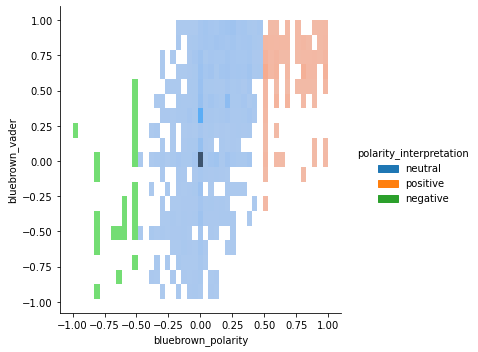

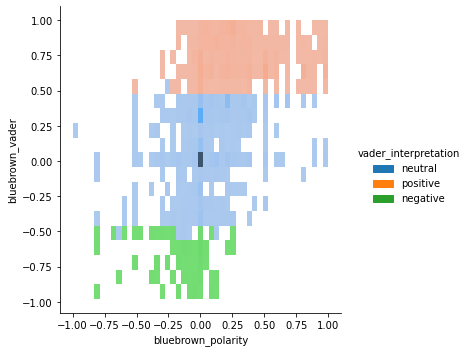

In [103]:
sns.displot(bluebrown_comments_df, x="bluebrown_polarity", y="bluebrown_vader", hue='polarity_interpretation')
sns.displot(bluebrown_comments_df, x="bluebrown_polarity", y="bluebrown_vader", hue='vader_interpretation')

We can see that common group for two ways of counting polarity is neutral part.

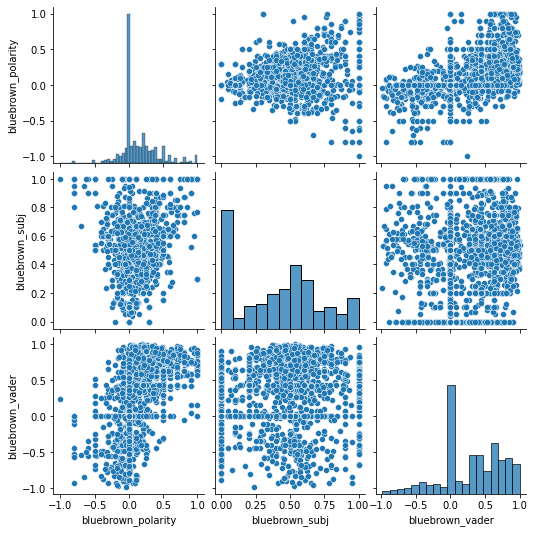

In [79]:
sns.pairplot(bluebrown_comments_df)

We can see that the most commont value is the neutral one for both ways of counting. The rest of the distributions of data is as expected from pie charts.

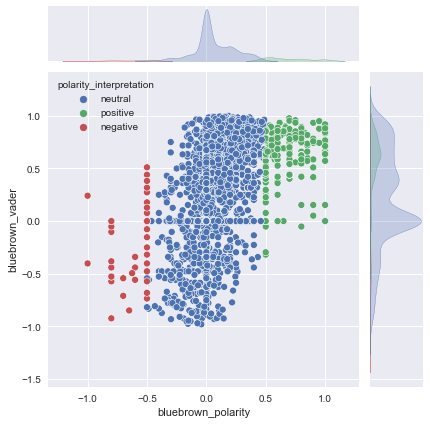

In [177]:
sns.jointplot(data=bluebrown_comments_df_all, x="bluebrown_polarity", y="bluebrown_vader", 
              hue="polarity_interpretation")

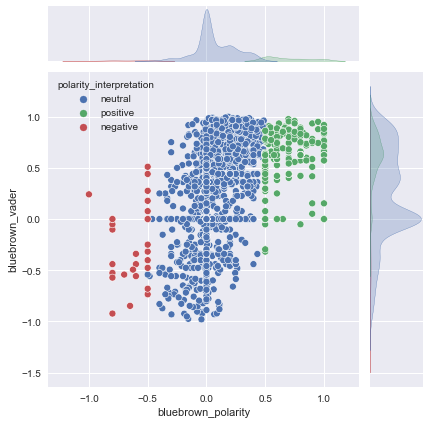

In [175]:
sns.jointplot(data=bluebrown_comments_df, x="bluebrown_polarity", y="bluebrown_vader", hue="polarity_interpretation")

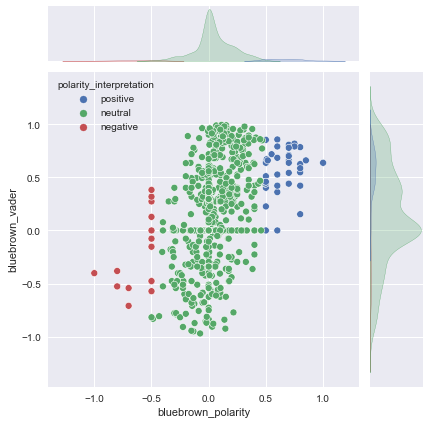

In [172]:
sns.jointplot(data=bluebrown_comments_df_rep, x="bluebrown_polarity", y="bluebrown_vader", hue="polarity_interpretation")

For all three datasets as expected the middle (neutral) is the most numerous group.

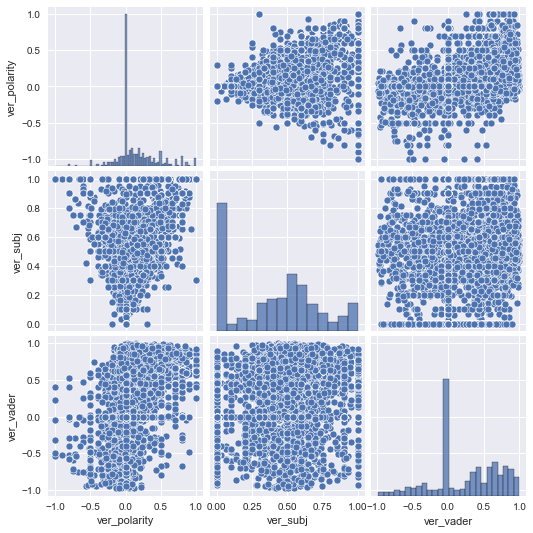

In [197]:
sns.pairplot(ver_comments_df)

As for the 3blue1brown channel the most common polarity value is neutral one. The rest of the distributions of data is as expected from pie charts.

# Summary

1. We have chosen the channels of the scientific part of youtube, which might have cost that the most common polarity of the comments is neutral. 
2. For one channel we are able to observe the pandemic impact on the content and overall activity.
3. In general, split for three groups in comments did't show any relevant changes. 
4. Replies are more neutral.
5. More scientific channel (3blue1brown) is less popular than popular science channel (Veritasium).
6. The videos with the longer duartion are watched less frequantly.